# Week 4 Assignment
## Los Angeles Chinatown Demographic Analysis Using the Aerican Community Survey (ACS)

<div class="alert alert-info">
Start by importing modules to gain access to their functions for data analysis.

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import folium
import plotly.express as px

## Median Household Income Data (Adjusted to 2021 Dollars)
#### Using Social Explorer
Los Angeles County Block Group Level:
- ACS 2017-2021
- ACS 2012-2016
- ACS 2007-2011

### Importing the Data

In [2]:
# Read and add ACS Median Household Income from 2007 to 2021
medinc_2017_2021 = pd.read_csv('Data/ACS 2021 5Y - Median Household Income.csv',
                              dtype = {
                                  'Geo_FIPS':str,
                                  'Geo_STATE':str,
                                  'Geo_COUNTY':str })

medinc_2012_2016 = pd.read_csv('Data/ACS 2016 5Y - Median Household Income (2021 Adjusted).csv',
                              dtype = {
                                  'Geo_FIPS':str,
                                  'Geo_STATE':str,
                                  'Geo_COUNTY':str })

medinc_2007_2011 = pd.read_csv('Data/ACS 2011 5Y - Median Household Income (2021 Adjusted).csv',
                              dtype = {
                                  'Geo_FIPS':str,
                                  'Geo_STATE':str,
                                  'Geo_COUNTY':str })

### Cleaning the Data

In [3]:
# List columns to keep

columns_to_keep = ['Geo_FIPS',
                   'SE_A14006_001']

# Update new dataframe to includes desired columns
medinc_2017_2021 = medinc_2017_2021[columns_to_keep]
medinc_2012_2016 = medinc_2012_2016[columns_to_keep]
medinc_2007_2011 = medinc_2007_2011[columns_to_keep]

# Rename column names
medinc_2017_2021.columns = ['GEOID', '2017-2021 Median Houshold Income']
medinc_2012_2016.columns = ['GEOID', '2012-2016 Median Houshold Income']
medinc_2007_2011.columns = ['GEOID', '2007-2011 Median Houshold Income']

In [4]:
# Checking to ensure that the dataframes have been updated correctly
medinc_2007_2011.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6425 entries, 0 to 6424
Data columns (total 2 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   GEOID                             6425 non-null   object 
 1   2007-2011 Median Houshold Income  6382 non-null   float64
dtypes: float64(1), object(1)
memory usage: 100.5+ KB


In [5]:
# Merging to create one dataframe with all income data
income_2007_2021 = medinc_2017_2021.merge(medinc_2012_2016, on='GEOID').merge(medinc_2007_2011, on='GEOID')

# Add column measuring percent change in median household income from 2007 to 2021
income_2007_2021_percent_change = (income_2007_2021['2017-2021 Median Houshold Income'] - income_2007_2021['2007-2011 Median Houshold Income'])/(income_2007_2021['2007-2011 Median Houshold Income']) * 100
income_2007_2021['2007-2021 Median Household Income Percent Change (%)'] = income_2007_2021_percent_change

# Check
income_2007_2021.head()

GEOID  2017-2021 Median Houshold Income  \
0  060371011101                           63242.0   
1  060371011102                           56250.0   
2  060371011103                           99567.0   
3  060371011221                          120833.0   
4  060371011222                           90536.0   

   2012-2016 Median Houshold Income  2007-2011 Median Houshold Income  \
0                           53380.0                           65302.0   
1                           49749.0                           54763.0   
2                           68845.0                           83421.0   
3                           98027.0                          109786.0   
4                           94489.0                          104126.0   

   2007-2021 Median Household Income Percent Change (%)  
0                                          -3.154574     
1                                           2.715337     
2                                          19.354839     
3                                          10.062303     
4                                         -13.051495

### Merging with Chinatown Census Block Groups

<div class="alert alert-info">
Important code to ensure that Chinatown geography is loaded into our dataset along with block groups within its boundaries. 

In [6]:
# Import Los Angeles Neighborhood Boundaries dataset
la_neighborhoods = gpd.read_file('Data/LA_Times_Neighborhood_Boundaries.zip')

# Filter dataset to get Chinatown geometry
la_chinatown = la_neighborhoods[la_neighborhoods['name'] == 'Chinatown']

# Import census block group geography
census_block_groups_2020 = gpd.read_file('Data/tl_2020_06_bg.zip')

# Extract census block groups within Chinatown
chinatown_bg = gpd.clip(census_block_groups_2020, la_chinatown)

# Identify columns to keep in Chinatown geography
chinatown_geo_keep = ['GEOID', 'INTPTLAT', 'INTPTLON', 'geometry']

# Update new dataframe to includes desired columns
chinatown_bg = chinatown_bg[chinatown_geo_keep]

# Chinatown block groups
chinatown_bg_list = chinatown_bg['GEOID'].tolist()

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
/tmp/ipykernel_7027/1611033366.py:11: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4269
Right CRS: EPSG:4326

  chinatown_bg = gpd.clip(census_block_groups_2020, la_chinatown)
/opt/conda/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


<div class="alert alert-info">
Time to merge variable of interest with Chinatown census block groups from above.

In [7]:
# Merge race change information to Chinatown block groups
chinatown_medinc = chinatown_bg.merge(income_2007_2021, on='GEOID')

# Check
chinatown_medinc


GEOID     INTPTLAT      INTPTLON  \
0   060372060201  +34.0571230  -118.2311021   
1   060372071021  +34.0592851  -118.2395097   
2   060372071011  +34.0625255  -118.2444447   
3   060372071032  +34.0644499  -118.2386266   
4   060372060102  +34.0640019  -118.2289441   
5   060372071031  +34.0646919  -118.2434341   
6   060371976001  +34.0659405  -118.2511285   
7   060371977002  +34.0656960  -118.2466858   
8   060371977003  +34.0683153  -118.2427034   
9   060371977001  +34.0702700  -118.2485182   
10  060372060101  +34.0718134  -118.2325370   
11  060379800101  +34.0786807  -118.2395140   

                                             geometry  \
0   POLYGON ((-118.23692 34.05880, -118.23678 34.0...   
1   POLYGON ((-118.24115 34.05906, -118.24134 34.0...   
2   POLYGON ((-118.24732 34.06383, -118.24706 34.0...   
3   POLYGON ((-118.24381 34.06386, -118.24367 34.0...   
4   POLYGON ((-118.23461 34.06206, -118.23410 34.0...   
5   POLYGON ((-118.24546 34.06473, -118.24522 34.0...   
6   POLYGON ((-118.24921 34.06520, -118.24920 34.0...   
7   POLYGON ((-118.24579 34.06690, -118.24415 34.0...   
8   POLYGON ((-118.24564 34.07098, -118.24206 34.0...   
9   POLYGON ((-118.24591 34.06893, -118.24616 34.0...   
10  MULTIPOLYGON (((-118.23923 34.06726, -118.2389...   
11  POLYGON ((-118.22545 34.07192, -118.22556 34.0...   

    2017-2021 Median Houshold Income  2012-2016 Median Houshold Income  \
0                           116500.0                           86089.0   
1                            31071.0                           21046.0   
2                            32721.0                           40952.0   
3                            20957.0                           23640.0   
4                            17111.0                           13860.0   
5                            75735.0                           38105.0   
6                            79509.0                           67234.0   
7                           103636.0                           32753.0   
8                            47125.0                           34468.0   
9                            53208.0                           37097.0   
10                           83946.0                           32584.0   
11                           40227.0                               NaN   

    2007-2011 Median Houshold Income  \
0                           124697.0   
1                            15014.0   
2                            20928.0   
3                            16043.0   
4                            15247.0   
5                            23748.0   
6                            51019.0   
7                            36566.0   
8                            47636.0   
9                            43445.0   
10                           26975.0   
11                           68361.0   

    2007-2021 Median Household Income Percent Change (%)  
0                                           -6.573534     
1                                          106.946850     
2                                           56.350344     
3                                           30.630181     
4                                           12.225356     
5                                          218.911066     
6                                           55.841941     
7                                          183.421758     
8                                           -1.072718     
9                                           22.472091     
10                                         211.199259     
11                                         -41.155045

## Creating Maps

In [8]:
# Create list of columns of subvariables

medinc_years = ['2017-2021 Median Houshold Income',
                '2012-2016 Median Houshold Income',
                '2007-2011 Median Houshold Income']

In [9]:
chinatown_medinc['2007-2011 Median Houshold Income'].max()

124697.0

### Using Folium

In [10]:
def medinc_map(period):
    medinc_map = folium.Map(location = [34.0623, -118.2383], tiles = 'OpenStreetMap', zoom_start = 15) # Chinatown coordinates from Google
    folium.Choropleth(geo_data = chinatown_medinc,
                      data = chinatown_medinc,
                      columns = ['GEOID', period],
                      key_on = 'feature.properties.GEOID',
                      fill_color = 'Spectral',
                      bins = [0, 20000, 40000, 60000, 80000, 100000, 120000, 140000],
                      line_weight=0.1, 
                      fill_opacity=0.8,
                      line_opacity=0.2,
                      legend_name = period).add_to(medinc_map)
    display(medinc_map)

In [11]:
for period in medinc_years:
    medinc_map(period)

### Using Plotly (Interactive)

In [12]:
def medinc_fig(period):
    medinc_fig = px.choropleth_mapbox(chinatown_medinc, 
                                      geojson= chinatown_medinc.geometry, 
                                      locations = chinatown_medinc.index,
                                      color= period,
                                      color_continuous_scale="Spectral",
                                      center = {"lat":34.0623, "lon":-118.2383},
                                      zoom = 13.25,
                                      opacity = 0.7,
                                      range_color = (0, 140000),
                                      mapbox_style = "open-street-map", # or carto-positron
                                      hover_data = [period],
                                      labels={period})

    medinc_fig.update_geos(fitbounds="locations", visible=True)

    medinc_fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    medinc_fig.update_traces(marker_line_width=0.5)

    medinc_fig.show()
    

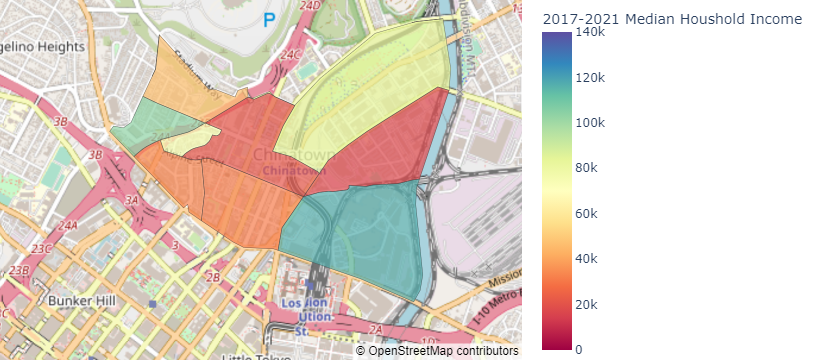

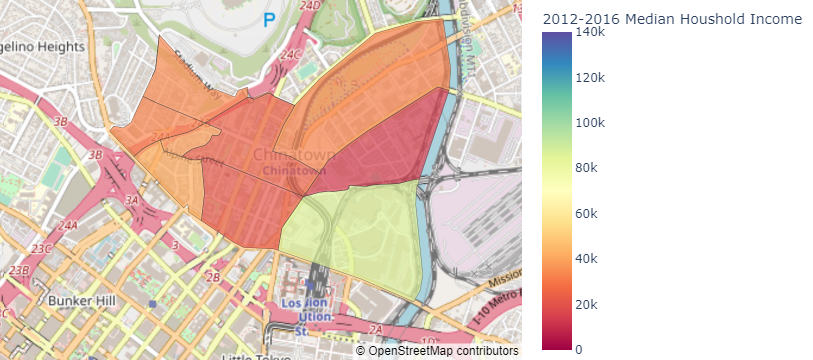

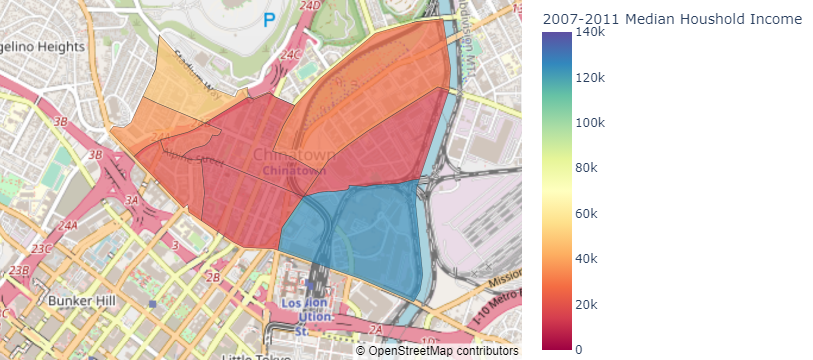

In [13]:
for period in medinc_years:
    medinc_fig(period)

Notes:

Should I add column for percent change?

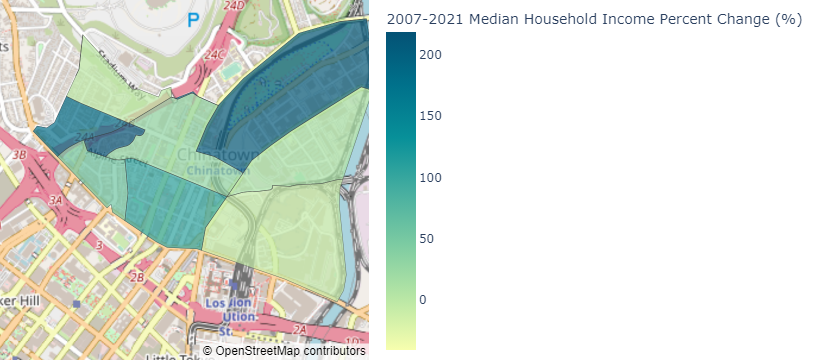

In [14]:
# Test
medinc_fig = px.choropleth_mapbox(chinatown_medinc, 
    geojson= chinatown_medinc.geometry, 
    locations = chinatown_medinc.index,
    color= '2007-2021 Median Household Income Percent Change (%)',
    color_continuous_scale="Bluyl",
    center = {"lat":34.0623, "lon":-118.2383},
    zoom = 13.25,
    opacity = 0.7,
    mapbox_style = "open-street-map", # or carto-positron
    hover_data = ['2007-2011 Median Houshold Income','2017-2021 Median Houshold Income'],
    labels={'2007-2011 Median Household Income','2017-2021 Median Houshold Income'})
medinc_fig.update_geos(fitbounds="locations", visible=True)

medinc_fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
medinc_fig.update_traces(marker_line_width=0.5)

medinc_fig.show()